In [2]:
import os
import time

import re
import copy
import numpy as np
import pandas as pd
import h5py
import tables
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx
import geopandas as gpd
from shapely.geometry import Point
import rasterio
import rioxarray as rxr
import math
import pickle
from pickle import dump
import sklearn
import graphviz
import xgboost as xgb
import lightgbm as lgbm
from platform import python_version

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from xgboost import cv
from xgboost import XGBRegressor
from xgboost import plot_importance as plot_importance_XGB
from lightgbm import LGBMRegressor
from lightgbm import plot_importance as plot_importance_LGBM

print(pd.__version__) # should be 1.3.0
print(sklearn.__version__) # should be 0.24.1
print(python_version())

1.3.5
1.0.2
0.19.1


In [3]:
os.getcwd()
os.chdir('..')
os.getcwd()
os.chdir('..')

'/uufs/chpc.utah.edu/common/home/civil-group1/ItalianAlps/SnowCast/Final_Model/Model'

In [42]:
### load regionalized geospatial data

### define regions
Region_list = ['N_Sierras',
               'S_Sierras_High',
               'S_Sierras_Low',
               'Greater_Yellowstone',
               'N_Co_Rockies',
               'SW_Mont',
               'SW_Co_Rockies',
               'GBasin',
               'N_Wasatch',
               'N_Cascade',
               'S_Wasatch',
               'SW_Mtns',
               'E_WA_N_Id_W_Mont',
               'S_Wyoming',
               'SE_Co_Rockies',
               'Sawtooth',
               'Ca_Coast',
               'E_Or',
               'N_Yellowstone',
               'S_Cascade',
               'Wa_Coast',
               'Greater_Glacier',
               'Or_Coast'
              ]
### Load H5 train files into dictionary
RegionTrain= {}
for region in Region_list:
    RegionTrain[region] = pd.read_hdf('Data/Model_Calibration_Data/RegionTrain_Final.h5', region)
    
    
### Load validation Dataset to confirm features 
val_dat0 =open("Data/Processed/ValidationDF_01_20_2022.pkl","rb")
Validation_dat0 = pickle.load(val_dat0)
    
#Remove missing validation features from Training data
RegionTrain_val_noPrevSWE={}
missing={}
for region in Region_list:
    RegionTrain_val_noPrevSWE[region] = RegionTrain[region].drop(['prev_SWE'], axis=1)
    missing[region] = RegionTrain[region].columns.difference(Validation_dat0[region].columns)
    missing[region] = missing[region].drop(list(['SWE','prev_SWE']))
    RegionTrain[region] = RegionTrain[region].drop(missing[region], axis=1)
    RegionTrain_val_noPrevSWE[region] = RegionTrain_val_noPrevSWE[region].drop(missing[region], axis=1)

###### Framework for a universal GB model class

In [44]:
### hyperparameter grid

LGBM_param_grid = {
    "max_depth": list(range(3,30,4)),
    "num_leaves": list(range(5,55,10)),
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 0.9],
    "n_estimators": list(range(300,700,100))  
}


In [4]:
class REGRESSOR(object):
    """
    Regression optimization model class.
    Args:
        target (str): target to be modeled.
        data (dict): Dictionary of dataframes containing training/testing data
        estimator (model object): type of model to be fit.
        param_grid (dict): hyperparameter grid
        model (fit XGBRegressor, LGBMRegessor, etc..): the fit model object
    """

    def __init__(self, target, data, estimator=None, param_grid=None, model=None):
        self.target = target
        self.data = data
        self.estimator = estimator 
        self.param_grid = param_grid
        self.model = model
        self.param_grid2 = param_grid
    
    @staticmethod
    def make_dataframe(region, data):
        """Dataframe manipulation."""
        
        df = data.get(region)
        
        ### replace -9999s with nans
        df=df.replace([-9999, -9999.99], np.nan)     
        
        ### create new index 0 - len(df)
        df= df.reset_index(drop=False)
        df =df.rename(columns={"index": "cell_id"})
        if 'Date' in df.columns:
            df = df.drop(columns=['Date']) 
        
        ###create indexed series of cell ids
        id_map = df.pop('cell_id').to_frame()
        id_map['Long'] = df['Long']
        id_map['Lat'] = df['Lat']
        id_map['WYWeek'] = df['WYWeek']
        id_map['elevation_m'] = df['elevation_m']

        ### shuffle dataframe
        df = df.sample(frac=1, random_state=1234)
        
        ### replace special character ':' with '__' 
        df = df.rename(columns = lambda x:re.sub(':', '__', x))
        
        return df, id_map

    def fit_(self, region, cv=5):
        """Gridsearch for Parmas, Fit model, and save as instance attribute."""
        start_time = time.time()

        ### Dataframe engineering step
        df, id_map = self.make_dataframe(region, self.data)

        y = df.pop(self.target)

 
        ###normalize features
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(df)
        df = pd.DataFrame(scaled, columns = df.columns)
        #save scaler data here
        pickle.dump(scaler, open(os.getcwd()+'/Model/Model_Calibration/Initial_LGBM/Scalers/'+'LGBM_'+region+'_scaler.pkl', 'wb'))
        
        X = df
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)


        ### Fit CV to define optimal hyperparmaeters
        gs = GridSearchCV(
            self.estimator(),
            self.param_grid,
            cv=5,
            n_jobs=-1,
            return_train_score=True,
            refit=False
        )

        gs.fit(X_train, y_train)

        self.best_score = gs.best_score_
        self.param_grid = gs.best_params_
        print('Best Score:', gs.best_score_)
        print('Best Params:', gs.best_params_)


        ### Fit the estimator model with the optimal params
        self.model = self.estimator(**self.param_grid)

        X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = self.Feature_selection(X_train, X_test, y_train, y_test)
        
        c_time = round(time.time() - start_time,2)
        print('Calibration time', round(c_time), 's')
        
        return X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe, id_map
    
    def Feature_selection(self, X_train, X_test, y_train, y_test):
        """Identify and and fit model with optimal features """
        ### Define RFE with CV model
        min_features_to_select = 1  # Minimum number of features to consider
        rfecv = RFECV(
            estimator=self.model,
            step=1,
            cv=5,
            n_jobs=-1,
            min_features_to_select=min_features_to_select,
        )
        
        rfecv.fit(X_train, y_train)

        ### dataframe of optimal features, remove non-optimal features from train/test data 
        feat = {'Features_raw': X_train.columns}
        RFECV_Feat = pd.DataFrame(data=feat)
        RFECV_Feat['Rank']= rfecv.ranking_
        RFECV_Feat['Selected']= rfecv.support_
        RFECV_Feat_opt = RFECV_Feat[RFECV_Feat['Selected']==True]
        RFECV_Feat_opt = RFECV_Feat_opt['Features_raw']
        RFECV_Feat_opt.columns=['Features_opt']
        print('The optimal features are: ', list(RFECV_Feat_opt))
        ### use optimal features for final fit data
        X_train=X_train[list(RFECV_Feat_opt)]
        X_test=X_test[list(RFECV_Feat_opt)]
        
        ### fit model with optimal parmas & optimal # of featuress
        self.model = self.estimator(**self.param_grid)
        self.model.fit(X_train, y_train)
        
        
        ### Plot number of features vs. cross-validation scores
        plt.figure()
        plt.xlabel("Number of features selected")
        plt.ylabel("Cross validation score (accuracy)")
        plt.plot(range(min_features_to_select, len(rfecv.cv_results_["mean_test_score"]) + min_features_to_select),
            rfecv.cv_results_["mean_test_score"])
        plt.show()

        print("Optimal number of features : %d" % rfecv.n_features_)

        ### Revert special character '__' with ':'
        X_train = X_train.rename(columns = lambda x:re.sub(r"(_)\1+", ':', x))
        X_test = X_test.rename(columns = lambda x:re.sub(r"(_)\1+", ':', x))
        
        return X_train, X_test, y_train, y_test
    
    
    def predict_(self, X_test):
        """Generate model predictions."""

        preds = (self.model.predict(X_test))
        
        ### correct negative predictions
        preds[preds <0]=0
        
        return preds



In [5]:
def Batch_Train(target, data, algorithm, parameter_grid, Region_list):
    """
    Batch train regression model and produce testing prediction.
    Args:
        algorithm (model object): Regressor to be fit (XGBRegressor, LGBMRgressor)
        param_grid (dict): Hyperparameter grid
        Region_list (list): List of regions to be evaluated
        models_dierctory (str): Root path of the dierctory to save models (ie. "Models/XGB")
        dictionary_directory (str): Root path of the dierctory to save output dictionaries (ie. "Models/XGB")
    """
    
    split_dict={}
    prediction_dict={}
    features_dict = {}
    ### define prefix for path based on algorithm desired
    if algorithm == XGBRegressor:
        path_name = 'XGB'
        from xgboost import plot_importance
    elif algorithm == LGBMRegressor:
        path_name = 'LGBM'
        from lightgbm import plot_importance
    else:
        raise ValueError("Algorithm not recognized. Must be XGBRegressor or LGBMRegressor.")
    
    for region in Region_list:
        ###Instantiate Model
        region_model = REGRESSOR(target=target, data=data, estimator=algorithm, param_grid=parameter_grid)
        
        ###Fit region model and add dictionary entry for region test-train data, save fit model to file.
        ###Dictformat is, split_dict{'region': [X_train, X_test, y_train, y_test, cell_id]}
        print(region,':')
        split_dict[region] = region_model.fit_(region)
        print('Saving Model')
        pickle.dump(region_model, open(os.getcwd()+"/Model/Model_Calibration/Initial_LGBM/LGBM_"+region+".pkl", "wb"))
        
        ###Generate predictions and add to prediction dictionary,
        ###Dict format is, prediction_dict{'region': [preds]}
        prediction_dict[region] = region_model.predict_(split_dict.get(region)[1])
        
        ### plot predictions
        fig, ax =plt.subplots()
        sns.set(style="whitegrid")
        plt.scatter(split_dict.get(region)[3], prediction_dict.get(region), marker='.',s=100, color = 'b')
        plt.plot([0,(prediction_dict.get(region).max()+10)], [0,(prediction_dict.get(region).max()+10)], ls="--", c=".1")
        plt.xlim([0, (split_dict.get(region)[3].max()+5)])
        plt.ylim([(prediction_dict.get(region).min()-1),(prediction_dict.get(region).max()+5)])
        ax.set_title(region)
        ax.set_xlabel("Truth")
        ax.set_ylabel("Prediction")
        plt.show()
        rmse = mean_squared_error(split_dict.get(region)[3], prediction_dict.get(region), squared=False)
        print(region, "RMSE:", (round(rmse,3)))
        
        ###Optimal Features dictionary 
        features_dict[region] = split_dict[region][0].columns

        
    ###Save output dictionaries to file
    pickle.dump(split_dict, open(os.getcwd()+"/Model/Model_Calibration/Initial_LGBM/Output/"+path_name+"_split_dict_initial.pkl", "wb"))
    pickle.dump(prediction_dict, open(os.getcwd()+"/Model/Model_Calibration/Initial_LGBM/Output/"+path_name+"_prediction_dict_initial.pkl", "wb"))
    pickle.dump(features_dict, open(os.getcwd()+"/Model/Model_Calibration/Initial_LGBM/Output/opt_features_initial.pkl", "wb"))
    
    return split_dict, prediction_dict



def Make_Prediction(model_folder_ext,Region_list, Eval_set):
    """
    Run regression model for defined region.
    Args:
        Region_list (list): List of regions to be evaluated
        Eval_set (dict): Dictionary of region dataframes to predict SWE on
    """
    preds={}
    for region in Region_list:
        lgbm_model_loaded = pickle.load(open(os.getcwd()+"/Model/Model_Calibration/Initial_LGBM/LGBM_"+region+".pkl", "rb"))    
        print(region+" Model:", lgbm_model_loaded.model)
    
        preds[region] = lgbm_model_loaded.predict_(Eval_set[region])
   
    ###Combine all predictions into final df format
    Eval_preds = copy.deepcopy(Eval_set)
    Eval_preds_df = pd.DataFrame()
    for region in Region_list:
        Eval_preds[region] = Eval_preds[region].reset_index(drop=False)
        Eval_preds[region]["SWE_pred"] = preds[region]
        Eval_preds[region]["Region"] = region
        Eval_preds[region] = Eval_preds[region].sort_index() 
        Eval_preds_df = Eval_preds_df.append(Eval_preds[region])#, ignore_index=True)
    Eval_preds_df = Eval_preds_df[[ 'cell_id','Long','Lat',
                                    'SWE_pred','WYWeek',
                                    'elevation_m','Region']]
    
    return Eval_preds_df


## LightGBM Run

In [ ]:
%%time
splits_LGBM , preds_LGBM = Batch_Train('SWE', RegionTrain_val_noPrevSWE, LGBMRegressor, LGBM_param_grid, Region_list)

N_Sierras :


In [56]:
#### Evaluate RMSE : initial RMSEs
RMSE_dict_lgbm={}
for region in Region_list:
    rmse = mean_squared_error(splits_LGBM.get(region)[3], preds_LGBM.get(region), squared=False)
    print(region, "RMSE:", (round(rmse,3)))
    RMSE_dict_lgbm[region]=rmse

### Calc Weighted RMSE
Total_RMSE = mean_squared_error(all_preds_df['y_test'], all_preds_df['y_pred'], squared = False)
print('\nWeighted RMSE:', round(Total_RMSE, 3))

N_Sierras RMSE: 1.997
S_Sierras_High RMSE: 2.597
S_Sierras_Low RMSE: 1.866
Greater_Yellowstone RMSE: 1.064
N_Co_Rockies RMSE: 1.011
SW_Mont RMSE: 1.043
SW_Co_Rockies RMSE: 1.123
GBasin RMSE: 1.008
N_Wasatch RMSE: 1.147
N_Cascade RMSE: 2.17
S_Wasatch RMSE: 0.947
SW_Mtns RMSE: 0.584
E_WA_N_Id_W_Mont RMSE: 1.344
S_Wyoming RMSE: 1.08
SE_Co_Rockies RMSE: 0.732
Sawtooth RMSE: 1.239
Ca_Coast RMSE: 4.304
E_Or RMSE: 1.021
N_Yellowstone RMSE: 1.034
S_Cascade RMSE: 1.439
Wa_Coast RMSE: 1.53
Greater_Glacier RMSE: 1.896
Or_Coast RMSE: 0.876

Weighted RMSE: 1.467


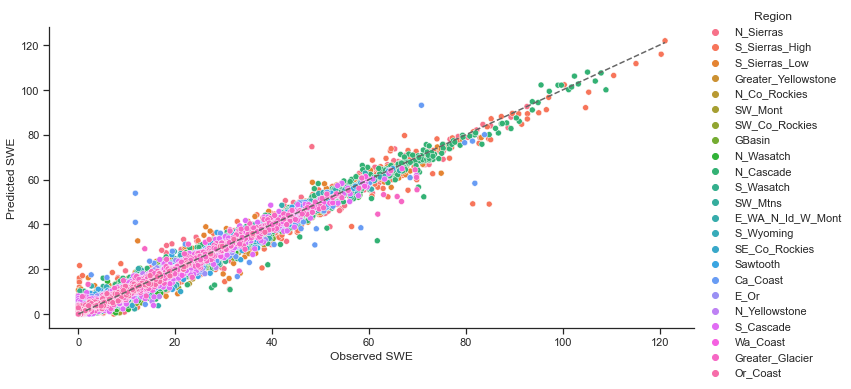

In [57]:
#Plot all region predictions together

sns.set(style='ticks')

SWEmax = max(all_preds_df['y_test'])

sns.relplot(data=all_preds_df, x='y_test', y='y_pred', hue='Region', hue_order=Region_list, aspect=2)
plt.plot([0,SWEmax], [0,SWEmax], color = '.4', linestyle = '--')
# plt.xlim([-1, 1])
# plt.ylim([(prediction_dict.get(region).min()-1),(prediction_dict.get(region).max()+5)])
plt.xlabel('Observed SWE')
plt.ylabel('Predicted SWE')
plt.show()